<a href="https://colab.research.google.com/github/beaten-by-the-market/krxnewsscrap/blob/main/krxvsnxt_cumul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 파이썬 세팅하고 조회일자 입력하기

In [1]:
#-----------------------------------------------------------
#필요한 패키지 import
#-----------------------------------------------------------
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import BytesIO
from matplotlib import font_manager, rc
import numpy as np
from datetime import datetime
from time import sleep
from tqdm.notebook import tqdm

print('파이썬 실행을 위한 패키지 설치중입니다. 20초정도 소요됩니다.')

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

# Matplotlib 폰트 캐시 삭제
font_manager.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
font_manager._load_fontmanager(try_read_cache=False)

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 조회할 날짜 선택하기
print('조회할 날짜를 YYYYMMDD 형태로 입력하고 엔터키를 치세요 (ex. 20250304)')
input_date = input()
# 날짜를 '오늘'로 지정하려면 : input_date = datetime.today().strftime('%Y%m%d')

파이썬 실행을 위한 패키지 설치중입니다. 20초정도 소요됩니다.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
조회할 날짜를 YYYYMMDD 형태로 입력하고 엔터키를 치세요 (ex. 20250304)
20250308


## NXT, KRX 데이터를 공개된 각사 홈페이지에서 조회하여 복사해오기

In [3]:
#-----------------------------------------------------------
#거래일 식별하기(11003 코스피 지수 시세에서 날짜를 추출하는 방식)
#-----------------------------------------------------------

#[12001] 전종목 시세
#거래소 홈페이지에서 불러오기
gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp = {
  "locale": "ko_KR",
  "tboxindIdx_finder_equidx0_0": "코스피",
  "indIdx": "1",
  "indIdx2": "001",
  "codeNmindIdx_finder_equidx0_0": "코스피",
  "param1indIdx_finder_equidx0_0": "",
  "strtDd": "20250304", # 넥스트레이드 영업개시일
  "endDd": input_date,
  "share": "2",
  "money": "3",
  "csvxls_isNo": "false",
  "name": "fileDown",
  "url" : "dbms/MDC/STAT/standard/MDCSTAT00301"
}
headers = {'Referer' : 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201',
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

otp = requests.post(gen_otp_url, gen_otp, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_trdays = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')

# 조회할 날짜 리스트 생성
lookup_dates = df_trdays['일자'].str.replace('/', '').tolist()

# 잠시 쉬기
sleep(0.5)

# 수집할 데이터프레임 생성
df_cumul = pd.DataFrame()

# 순회하면서 수집
for loop_date in tqdm(lookup_dates, desc="NXT와 KRX의 대외공개된 홈페이지에서 데이터 수집중"):
  try:
    #-----------------------------------------------------------
    #데이터 불러오기(NXT와 KRX 모두)
    #-----------------------------------------------------------
    # 넥스트레이드
    url = 'https://www.nextrade.co.kr/brdinfoTime/brdinfoTimeList.do'

    params = {
        "_search": False,
        "nd": 1741120157913,
        "pageUnit": 900,
        "pageIndex": 1,
        "sidx": "",
        "sord": "asc",
        "scAggDd": loop_date,
        "scMktId": "",
        "searchKeyword": ""
    }

    # POST 요청
    response = requests.post(url, params=params)
    data = response.json()  # JSON 데이터 변환

    # 필요한 데이터 리스트 추출
    brdinfo_list = data.get("brdinfoTimeList", [])

    # 데이터프레임 전환
    df1 = pd.DataFrame(brdinfo_list)
    df_nxt = df1[['isuSrdCd', 'isuAbwdNm', 'mktNm', 'curPrc', 'contrastPrc', 'upDownRate', 'oppr', 'hgpr', 'lwpr', 'accTdQty', 'accTrval', 'tdhlYn']]

    # 데이터프레임으로 변환할 컬럼 정의
    df_nxt.columns = ['종목코드', '종목명', '시장구분', '현재가', '대비', '등락률', '시가', '고가', '저가', '거래량', '거래대금', '거래정지']

    #종목코드의 첫 앞의 A를 제거하기
    df_nxt = df_nxt.copy()  # 명시적으로 새로운 데이터프레임 생성
    df_nxt['종목코드'] = df_nxt['종목코드'].str.replace('A', '', regex=True)

    # 필요한 칼럼만 남기기
    df_nxt = df_nxt[['종목코드', '종목명', '시장구분', '현재가', '등락률', '거래량', '거래대금']]

    # 칼럼명 변경하기
    df_nxt = df_nxt.rename(columns={'현재가': 'NXT현재가', '등락률': 'NXT등락률', '거래량': 'NXT거래량', '거래대금':'NXT거래대금'})

    #-----------------------------------------------------------
    #정보데이터시스템에서 불러오는 과정
    #-----------------------------------------------------------

    #[12001] 전종목 시세
    #거래소 홈페이지에서 불러오기
    gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
    gen_otp = {
        'locale' : 'ko_KR',
        'mktId': 'ALL',
        'trdDd': loop_date,
        'share': '1',
        'money': '1',
        'csvxls_isNo': 'false',
        'name': 'fileDown',
        'url': 'dbms/MDC/STAT/standard/MDCSTAT01501'
        }

    headers = {'Referer' : 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020201',
              'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    otp = requests.post(gen_otp_url, gen_otp, headers = headers).text

    down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
    down_content = requests.post(down_url, {'code': otp}, headers = headers)


    df_krx = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')
    df_krx['시장구분'] = df_krx['시장구분'].replace('KOSDAQ GLOBAL', 'KOSDAQ')
    df_krx = df_krx.rename(columns=({'단축코드':'stock_code'}))

    # 필요한 칼럼만 남기기
    df_krx = df_krx[['종목코드', '종가', '등락률', '거래량', '거래대금', '시가총액']]

    # 칼럼명 변경하기
    df_krx = df_krx.rename(columns={'종가': 'KRX종가','등락률': 'KRX종가등락률', '거래량': 'KRX거래량', '거래대금': 'KRX거래대금'})


    # 데이터 합치기
    df_agg = pd.merge(df_nxt, df_krx, on='종목코드', how='left')
    df_agg['거래량비중'] = 100*(df_agg['NXT거래량']/df_agg['KRX거래량'])
    df_agg['거래대금비중'] = 100*(df_agg['NXT거래대금']/df_agg['KRX거래대금'])

    # 넥스트레이드 기준 날짜 및 시각 출력
    if data.get("brdinfoTimeList"):
        now_date = data["setTime"]
        print(f"{now_date} 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.")
    else:
        print("데이터가 없습니다.")

    # 수집일 칼럼으로 추가하기
    df_agg['수집일'] = loop_date

    # 데이터프레임 출력
    df_agg = df_agg.copy()[['수집일', '시장구분', '종목코드', '종목명', '시가총액', 'NXT거래량', 'KRX거래량', '거래량비중', 'NXT거래대금','KRX거래대금','거래대금비중']]

    # 합치기
    df_cumul = pd.concat([df_cumul, df_agg], axis = 0)

    # 부하 방지를 위한 쉬어가기
    sleep(0.5)

  except:
    print(f'{loop_date} 날짜의 수집과정에서 에러 발생')
    pass

NXT와 KRX의 대외공개된 홈페이지에서 데이터 수집중:   0%|          | 0/4 [00:00<?, ?it/s]

2025-03-07 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-06 20:05 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-05 20:00 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.
2025-03-04 20:00 기준 데이터를 NXT와 KRX의 대외공개 홈페이지에서 확인했습니다.


## 취합하여 데이터프레임으로 만들고 표출하기

In [4]:
# 날짜별 데이터프레임 생성
df_bydate = df_cumul.groupby('수집일').agg({
    'NXT거래량': 'sum',
    'KRX거래량': 'sum',
    'NXT거래대금': 'sum',
    'KRX거래대금': 'sum'
}).reset_index()

# 당일거래량비중과 당일거래대금비중 계산
df_bydate['당일거래량비중'] = (df_bydate['NXT거래량'] / df_bydate['KRX거래량']) * 100
df_bydate['당일거래대금비중'] = (df_bydate['NXT거래대금'] / df_bydate['KRX거래대금']) * 100

# 종목별 데이터프레임 생성
df_bystock = df_cumul.groupby(['종목코드', '종목명', '시장구분']).agg({
    'NXT거래량': 'sum',
    'KRX거래량': 'sum',
    'NXT거래대금': 'sum',
    'KRX거래대금': 'sum',
    '시가총액': 'first'  # 각 종목의 첫 번째 시가총액 값 사용
}).reset_index()

# 기간거래량비중과 기간거래대금비중 계산
df_bystock['기간거래량비중'] = (df_bystock['NXT거래량'] / df_bystock['KRX거래량']) * 100
df_bystock['기간거래대금비중'] = (df_bystock['NXT거래대금'] / df_bystock['KRX거래대금']) * 100

# 거래량 비중 기준으로 정렬하기
df_bystock = df_bystock.copy().sort_values(by='기간거래량비중', ascending=False)

# 숫자 형식 변환 함수
def format_number(value):
    if isinstance(value, (int, float)):
        return f"{value:,.0f}"  # 천 단위 콤마 추가, 소수점 없이 정수 출력
    return value

def format_percentage(value):
    if isinstance(value, (int, float)):
        return f"{value:.2f}"  # 소수점 2자리까지 출력
    return value

def format_market_cap(value):
    if isinstance(value, (int, float)):
        return f"{value / 100000000:,.0f}"  # 억원 단위 변환 후 천 단위 콤마 추가
    return value

# 서식적용할 데이터프레임 복사
df_bydate_show = df_bydate.copy()
df_bystock_show = df_bystock.copy()

# 1. 거래량 칼럼에 format_number 적용
df_bydate_show[['NXT거래량', 'KRX거래량']] = df_bydate_show[['NXT거래량', 'KRX거래량']].map(format_number)
df_bystock_show[['NXT거래량', 'KRX거래량']] = df_bystock_show[['NXT거래량', 'KRX거래량']].map(format_number)

# 2. 거래대금과 시가총액 칼럼에 format_market_cap 적용 (억원 단위)
df_bydate_show[['NXT거래대금', 'KRX거래대금']] = df_bydate_show[['NXT거래대금', 'KRX거래대금']].map(format_market_cap)
df_bystock_show[['NXT거래대금', 'KRX거래대금', '시가총액']] = df_bystock_show[['NXT거래대금', 'KRX거래대금', '시가총액']].map(format_market_cap)

# 3. 비중 칼럼에 format_percentage 적용
df_bydate_show[['당일거래량비중', '당일거래대금비중']] = df_bydate_show[['당일거래량비중', '당일거래대금비중']].map(format_percentage)
df_bystock_show[['기간거래량비중', '기간거래대금비중']] = df_bystock_show[['기간거래량비중', '기간거래대금비중']].map(format_percentage)

# 칼럼명 수정
df_bystock_show = df_bystock_show.rename(columns={'시가총액': '시가총액(억원)', 'KRX거래대금':'KRX거래대금(억원)', 'NXT거래대금':'NXT거래대금(억원)'})
df_bydate_show = df_bydate_show.rename(columns={'시가총액': '시가총액(억원)', 'KRX거래대금':'KRX거래대금(억원)', 'NXT거래대금':'NXT거래대금(억원)'})

# 칼럼순서 수정
df_bydate_show = df_bydate_show[['수집일', '당일거래량비중','NXT거래량', 'KRX거래량', '당일거래대금비중', 'NXT거래대금(억원)', 'KRX거래대금(억원)']]
df_bystock_show = df_bystock_show[['종목코드', '종목명', '시장구분','시가총액(억원)','기간거래량비중', 'NXT거래량', 'KRX거래량', '기간거래대금비중', 'NXT거래대금(억원)', 'KRX거래대금(억원)']]

# 출력
period = df_bydate_show.수집일.min()+' ~ '+df_bydate_show.수집일.max()
print(f'\n\n{period} 기간동안 전체 종목의 거래량, 거래대금 합계 및 비중')
display(df_bydate_show)
print(f'\n\n{period} 기간동안 종목별 거래량, 거래대금 합계 및 비중')
display(df_bystock_show)



20250304 ~ 20250307 기간동안 전체 종목의 거래량, 거래대금 합계 및 비중


,수집일,당일거래량비중,NXT거래량,KRX거래량,당일거래대금비중,NXT거래대금(억원),KRX거래대금(억원)
0,20250304,18.76,"434,890","2,318,056",29.33,202,689
1,20250305,41.89,"1,012,370","2,416,940",36.47,240,657
2,20250306,38.78,"665,408","1,715,929",35.22,172,489
3,20250307,40.93,"863,477","2,109,772",35.07,185,529




20250304 ~ 20250307 기간동안 종목별 거래량, 거래대금 합계 및 비중


,종목코드,종목명,시장구분,시가총액(억원),기간거래량비중,NXT거래량,KRX거래량,기간거래대금비중,NXT거래대금(억원),KRX거래대금(억원)
6,086450,동국제약,KOSDAQ,"6,976",88.31,"1,379,246","1,561,810",88.66,223,251
8,122870,와이지엔터테인먼트,KOSDAQ,"11,682",42.29,"504,461","1,192,780",42.95,326,758
9,215000,골프존,KOSDAQ,"3,759",39.98,"14,883","37,222",40.23,9,22
4,056190,에스에프에이,KOSDAQ,"7,103",28.59,"210,296","735,576",29.38,43,146
5,078340,컴투스,KOSDAQ,"5,528",27.71,"41,527","149,859",27.73,18,67
7,120110,코오롱인더,KOSPI,"9,467",26.08,"113,943","436,864",26.15,39,150
3,032640,LG유플러스,KOSPI,"46,106",19.30,"500,239","2,591,328",19.36,53,275
1,023530,롯데쇼핑,KOSPI,"19,123",14.21,"55,876","393,336",14.18,37,262
0,010950,S-Oil,KOSPI,"64,397",13.32,"60,209","452,151",13.33,34,256
2,030000,제일기획,KOSPI,"20,121",9.45,"95,465","1,009,771",9.45,17,176


## 데이터 시각화해서 보기

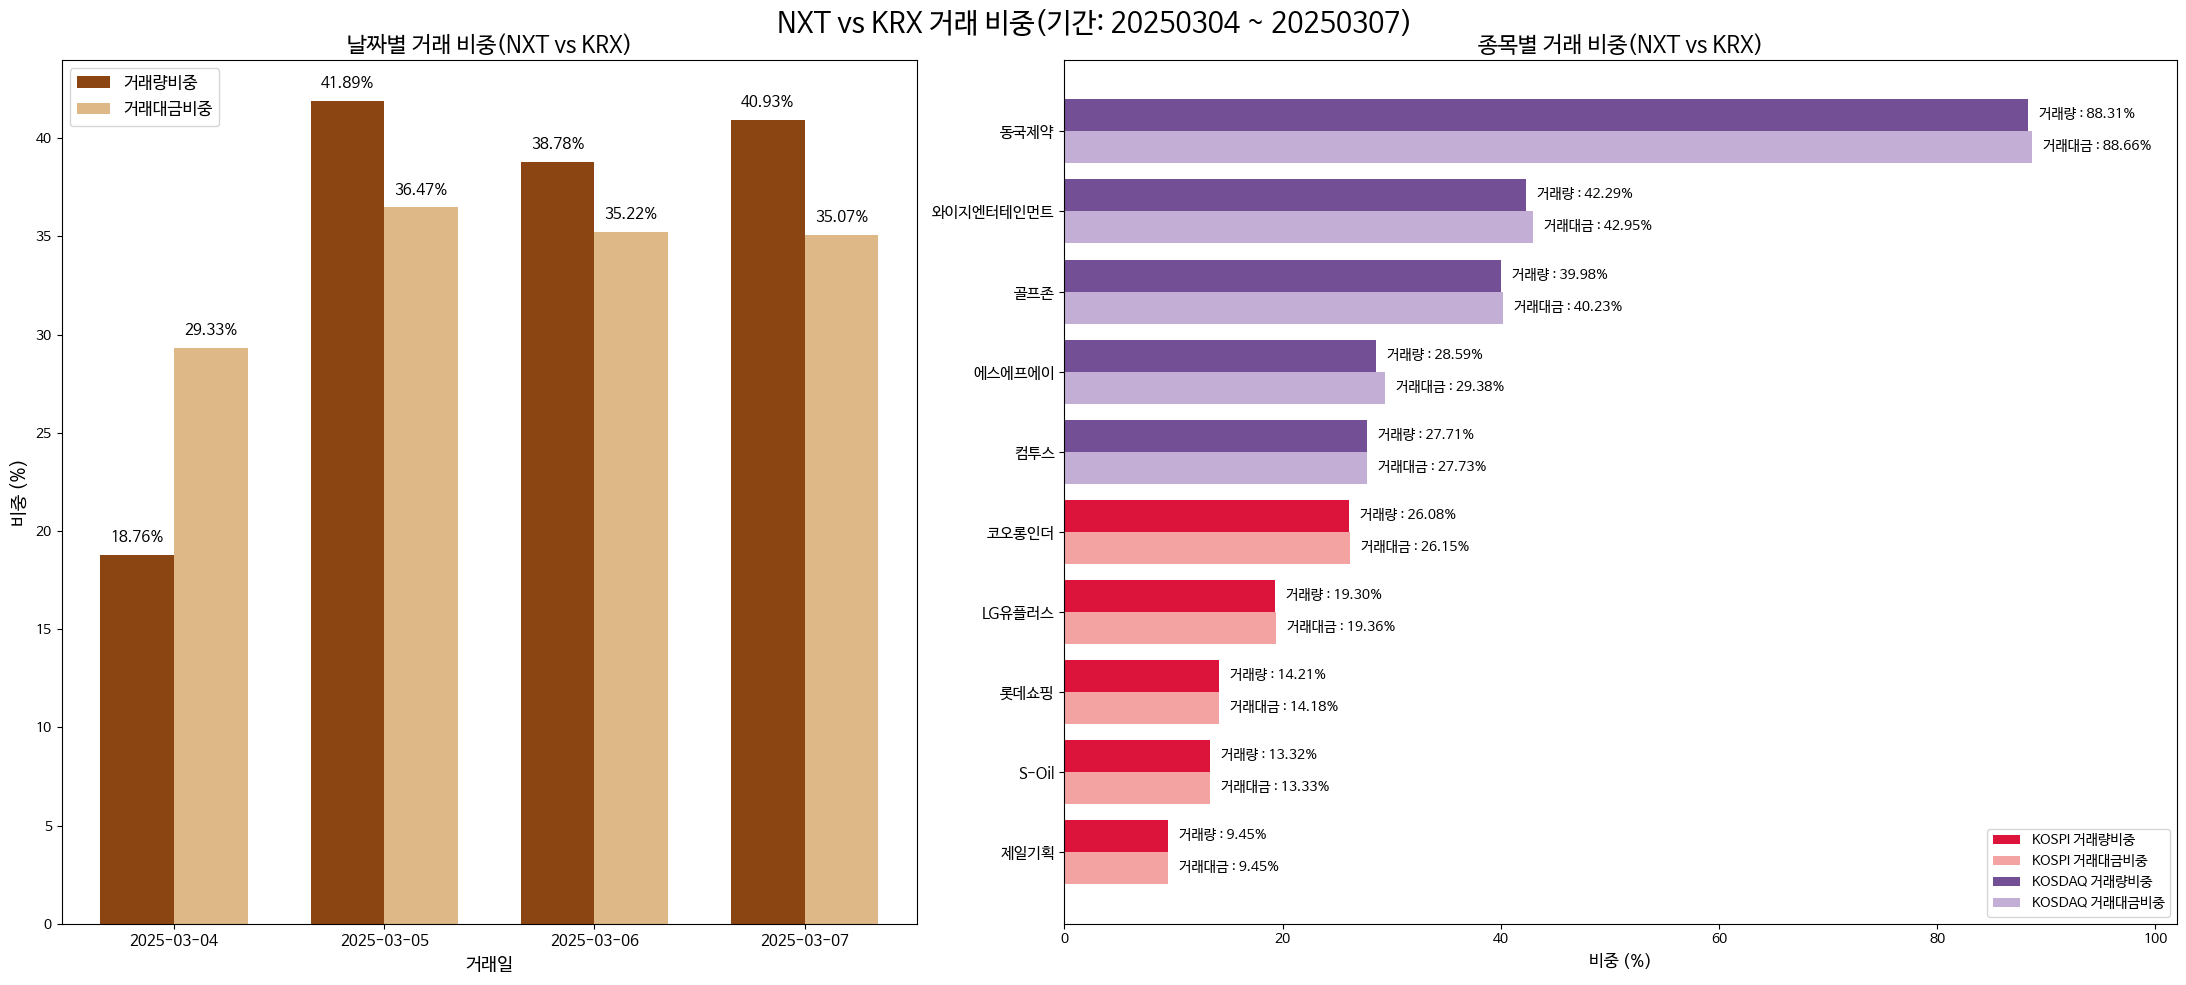

In [5]:
# 두 개의 서브플롯을 포함하는 하나의 figure 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10), gridspec_kw={'width_ratios': [1, 1.3]})

# ============= 왼쪽 그래프: 날짜별 데이터 =============
# 날짜 형식 변환
df_bydate['수집일'] = pd.to_datetime(df_bydate['수집일'], format='%Y%m%d')

# 막대 너비 설정
bar_width = 0.35

# X축 위치 설정
x = np.arange(len(df_bydate))

# 막대 그래프 그리기
bars1 = ax1.bar(x - bar_width / 2, df_bydate['당일거래량비중'], bar_width, label='거래량비중', color='#8B4513')
bars2 = ax1.bar(x + bar_width / 2, df_bydate['당일거래대금비중'], bar_width, label='거래대금비중', color='#DEB887')

# 데이터 레이블 추가
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom', fontsize=11)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}%', ha='center', va='bottom', fontsize=11)

# X축 및 Y축 레이블 설정
ax1.set_xlabel('거래일', fontsize=13)
ax1.set_ylabel('비중 (%)', fontsize=13)
ax1.set_title('날짜별 거래 비중(NXT vs KRX)', fontsize=16)

# X축 눈금 설정
ax1.set_xticks(x)
ax1.set_xticklabels(df_bydate['수집일'].dt.strftime('%Y-%m-%d'), fontsize=11)

# 범례 추가
ax1.legend(fontsize=12)

# ============= 오른쪽 그래프: 종목별 데이터 =============
# 거래량 기준 내림차순 정렬
df_bystock = df_bystock.sort_values(by='기간거래량비중', ascending=False)

# 색상 지정
colors_volume = np.where(df_bystock['시장구분'] == 'KOSPI', 'crimson', '#734F96')
colors_value = np.where(df_bystock['시장구분'] == 'KOSPI', '#F4A3A3', '#C3AED6')

# 막대 너비 설정
bar_width = 0.4

# Y축 위치 설정
y = np.arange(len(df_bystock))

# 가로 막대 그래프 그리기
bars1 = ax2.barh(y - bar_width / 2, df_bystock['기간거래량비중'], bar_width, label='거래량비중 (%)', color=colors_volume)
bars2 = ax2.barh(y + bar_width / 2, df_bystock['기간거래대금비중'], bar_width, label='거래대금비중 (%)', color=colors_value)

# 데이터 레이블 추가
for bar in bars1:
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height() / 2,
            f'거래량 : {width:.2f}%', ha='left', va='center', fontsize=10)

for bar in bars2:
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height() / 2,
            f'거래대금 : {width:.2f}%', ha='left', va='center', fontsize=10)

# Y축 레이블 설정
ax2.set_yticks(y)
ax2.set_yticklabels(df_bystock['종목명'], fontsize=11)

# X축 및 Y축 레이블 설정
ax2.set_xlabel('비중 (%)', fontsize=12)
ax2.set_title('종목별 거래 비중(NXT vs KRX)', fontsize=16)

# Y축 반전
ax2.invert_yaxis()

# 오른쪽 그래프 X축 여유 공간 확보
max_value = max(df_bystock['기간거래량비중'].max(), df_bystock['기간거래대금비중'].max())
ax2.set_xlim(0, max_value * 1.15)  # 15% 여유 공간

# 범례 추가
volume_patch_kospi = plt.Rectangle((0,0),1,1,fc="crimson", edgecolor='none')
volume_patch_kosdaq = plt.Rectangle((0,0),1,1,fc="#734F96", edgecolor='none')
value_patch_kospi = plt.Rectangle((0,0),1,1,fc="#F4A3A3", edgecolor='none')
value_patch_kosdaq = plt.Rectangle((0,0),1,1,fc="#C3AED6", edgecolor='none')

ax2.legend([volume_patch_kospi, value_patch_kospi,
            volume_patch_kosdaq, value_patch_kosdaq],
           ['KOSPI 거래량비중', 'KOSPI 거래대금비중',
            'KOSDAQ 거래량비중', 'KOSDAQ 거래대금비중'], fontsize=10, loc='lower right')

# 전체 그림 제목 (상단에 표시)
plt.suptitle(f'NXT vs KRX 거래 비중(기간: {period})', fontsize=20)

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.93)  # 상단 여백 추가 (전체 제목 표시)

plt.show()


[(링크)[그래픽] 종목별 한국거래소 대비 넥스트레이드 거래량 비중](https://www.yna.co.kr/view/GYH20250304001100044?input=1363m)

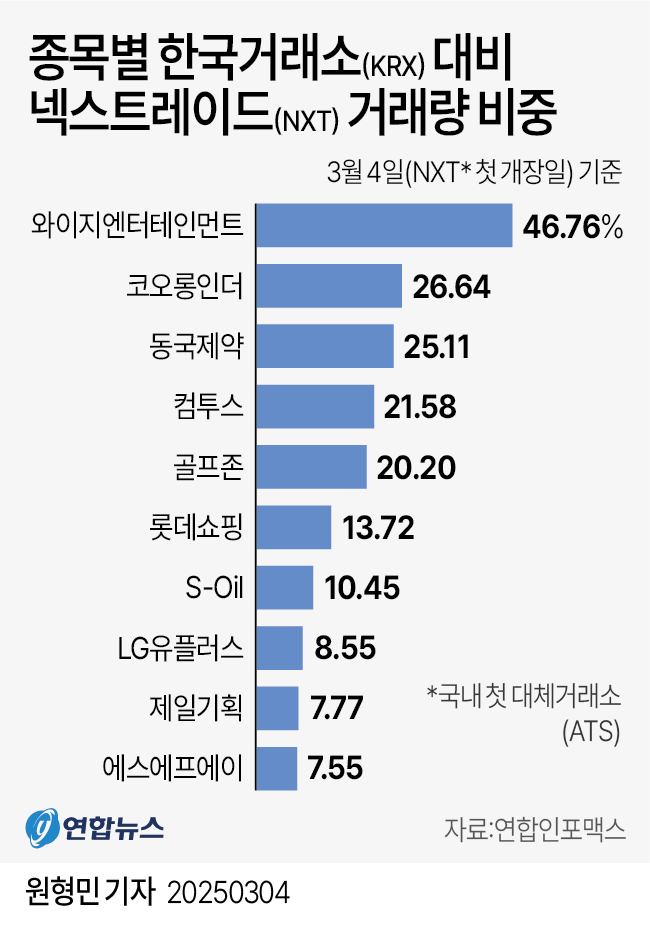